In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

__import__("importlib").reload(__import__("visenet"))
from visenet import ViSeNet, INPUT_SHAPE

2023-08-26 12:30:52.071391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def imshow(img):
    plt.axis('off')
    plt.imshow(
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    )
    plt.show()

Preprocessing data for the model

In [3]:
TIME_RANGE = INPUT_SHAPE[0]
FOLDER_PATH = "./DAVIS/{}/480p/{}"

def video_data_generator(n_repeat=1):
    for folder in os.listdir(FOLDER_PATH.format("Annotations", "")):

        for _ in range(n_repeat):

            if folder == ".DS_Store":
                continue

            # determine the frames in the video
            frames = os.listdir(FOLDER_PATH.format("Annotations", folder))
            if len(frames) < TIME_RANGE:
                continue

            # obtain data for each frame
            real_video, mask_video = [], []
            for step in frames[:32]:

                # get the real video
                real = cv2.imread(FOLDER_PATH.format("JPEGImages", f"{folder}/{step.replace('.png', '.jpg')}"))
                mask = cv2.imread(FOLDER_PATH.format("Annotations", f"{folder}/{step}"))

                # process the data
                real = cv2.resize(real, (128, 128))
                _, mask = cv2.threshold(cv2.resize(mask, (128, 128)), 150, 255, cv2.THRESH_BINARY)

                mask_video.append(mask / 255)
                real_video.append(real / 255)
                
            yield np.array([real_video]), np.array([mask_video])

# debugging purposes
for video, mask in video_data_generator():
    break

In [4]:
model = ViSeNet(vdepth=3, learning_rate=5e-3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 128, 128, 3)]    0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 128, 128, 64)     14144     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32, 128, 128, 64)     49280     ['sequential[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 32, 128, 128, 64)     256       ['sequential_1[0][0]']        
 Normalization)                                                                               

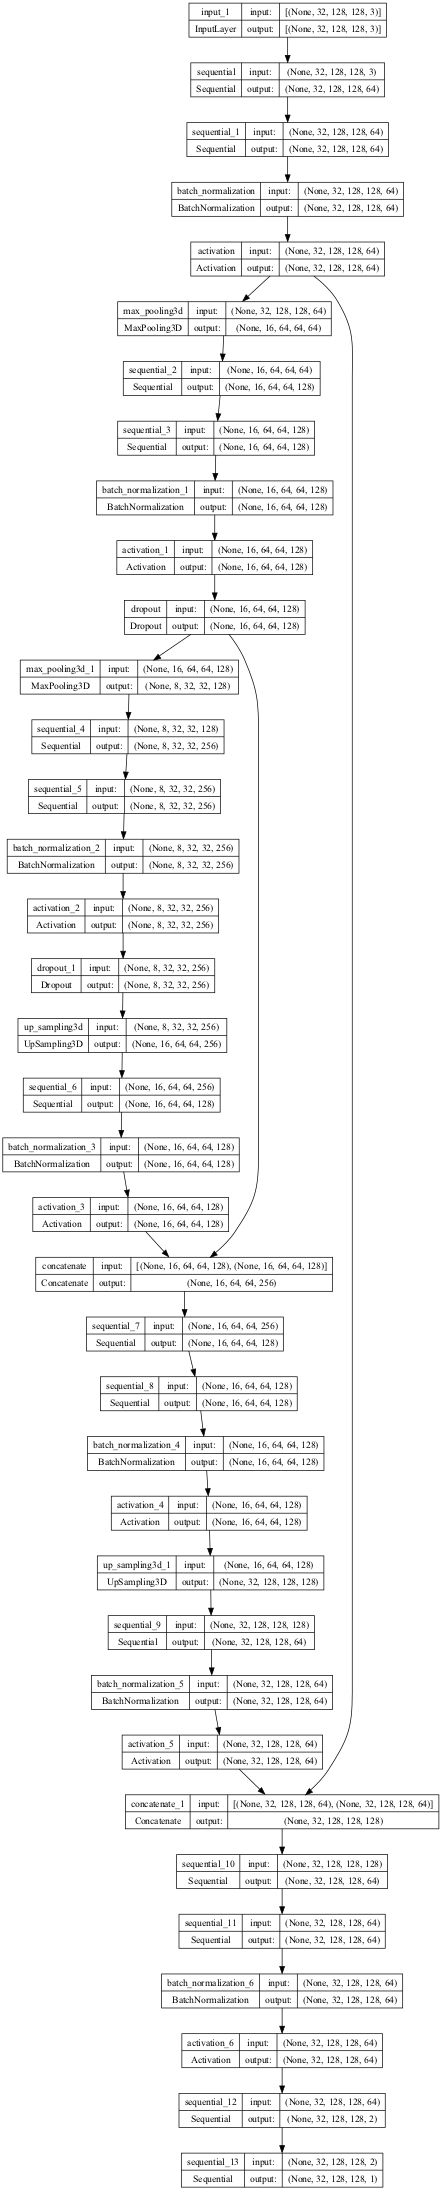

In [5]:
plot_model(model, show_shapes=True, expand_nested=False, dpi=50)

Overfit the model to test if it can work

In [6]:
model.fit(video_data_generator(n_repeat=500), steps_per_epoch=100, epochs=5)

Epoch 1/5
100/100 [==============================] - 1171s 12s/step - loss: 0.0776 - accuracy: 0.9307
Epoch 2/5
100/100 [==============================] - 1155s 12s/step - loss: 0.0564 - accuracy: 0.9888
Epoch 3/5
100/100 [==============================] - 1167s 12s/step - loss: 0.0427 - accuracy: 0.9912
Epoch 4/5
100/100 [==============================] - 1163s 12s/step - loss: 0.0352 - accuracy: 0.9838
Epoch 5/5
100/100 [==============================] - 1164s 12s/step - loss: 0.0272 - accuracy: 0.9906


Get first value of generator and exit, display result on that video

1/1 [==============================] - 2s 2s/step


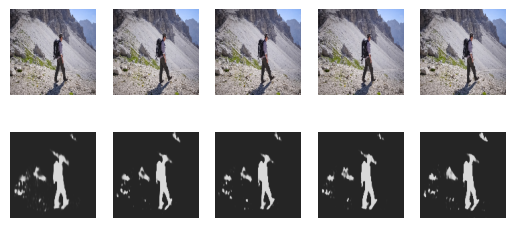

In [8]:
NUM_DISPLAYED = 5
for video, _ in video_data_generator():
    
    mask = model.predict(video)

    figure, axis = plt.subplots(2, NUM_DISPLAYED)
    plt.subplots_adjust(hspace=-0.5)
    for i in range(NUM_DISPLAYED):
        example_vid = (video[0][i] * 255).astype(np.uint8)
        example_mask = (mask[0][i] > 0.5).astype(np.uint8) * 255
        raw_mask = (mask[0][i] * 255).astype(np.uint8)

        axis[0, i].axis('off')
        axis[0, i].imshow(cv2.cvtColor(example_vid, cv2.COLOR_BGR2RGB))
        axis[1, i].axis('off')
        axis[1, i].imshow(cv2.cvtColor(raw_mask, cv2.COLOR_BGR2RGB))

    plt.show()

    break